# ASSIGNMENT
- Use the Caterpillar dataset (or _any_ dataset of your choice). **Make these 3 types of visualizations** for model interpretation:
  - Feature Importances
  - Permutation Importances
  - Partial Dependence Plot
- **Share at least 1 of your visualizations on Slack.**
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Shapely value plots
- Improve your scores on Kaggle! Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas. **Share your best features and techniques on Slack.**
- Try the [Skater library](https://oracle.github.io/Skater/index.html), which is an another option to get permutation importances and partial dependence plots.
- Can you figure out partial dependence plots with categorical features?
- Check out the links at the top of this notebook to learn more about how to interpret "black box" machine learning models.

In [0]:
!pip install eli5 pdpbox category_encoders shap

In [0]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

In [0]:
!unzip caterpillar-tube-pricing.zip

In [0]:
!unzip data.zip

In [0]:
import warnings
import numpy as np
import pandas as pd
from glob import glob
import category_encoders as ce
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

In [0]:
SOURCE = 'competition_data/'

## Load, clean and merge datasets

In [23]:
# Get a tidy list of the component id's in each tube assembly
materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')

assembly_components = materials.melt(id_vars='tube_assembly_id', 
                                     value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns={'value': 'component_id'}))
# Merge with component types
components = pd.read_csv(SOURCE + 'components.csv')
assembly_component_types = assembly_components.merge(components, how='left')
# Make a crosstab of the component types for each assembly (one-hot encoding)
table = pd.crosstab(assembly_component_types['tube_assembly_id'], 
                    assembly_component_types['component_type_id'])

table = table.reset_index()
table.columns.name = ''
print(table.shape)
table.head()

(19149, 30)


,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,CP-010,CP-011,CP-012,CP-014,CP-015,CP-016,CP-017,CP-018,CP-019,CP-020,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [20]:
# Most of the component files have a "weight" feature
ef search_column(name):
    for path in glob(SOURCE + '*.csv'):
        df = pd.read_csv(path)
        if name in df.columns:
            print(path, df.shape)
            print(df.columns.tolist(), '\n')

search_column('weight')

competition_data/comp_float.csv (16, 7)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'thickness', 'orientation', 'weight'] 

competition_data/comp_tee.csv (4, 14)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length', 'thickness', 'drop_length', 'mj_class_code', 'mj_plug_class_code', 'groove', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_elbow.csv (178, 16)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length', 'thickness', 'drop_length', 'elbow_angle', 'mj_class_code', 'mj_plug_class_code', 'plug_diameter', 'groove', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_nut.csv (65, 11)
['component_id', 'component_type_id', 'hex_nut_size', 'seat_angle', 'length', 'thread_size', 'thread_pitch', 'diameter', 'blind_hole', 'orientation', 'weight'] 

competition_data/comp_straight.csv (361, 12)
['

In [21]:
# Most of the component files have "orientation" binary features
comp_threaded = pd.read_csv(SOURCE + 'comp_threaded.csv')
comp_threaded['orientation'].value_counts()

No     121
Yes     73
Name: orientation, dtype: int64

In [22]:
# Most of the component files have "unique_feature" binary features
comp_threaded['unique_feature'].value_counts()

No     161
Yes     33
Name: unique_feature, dtype: int64

In [0]:
# Read all the component files and concatenate them together
comp = pd.concat((pd.read_csv(path) for path in glob(SOURCE + 'comp_*.csv')), sort=False)
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[columns]
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

In [25]:
# Engineer features, aggregated for all components in a tube assembly
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0)  for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, left_on=f'component_id_{n}', right_on='component_id', 
                                how='left', suffixes=('', f'_{n}'))

for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,orientation,unique_feature,weight,component_id,component_type_id,orientation_1,unique_feature_1,weight_1,component_id_2,component_type_id_2,orientation_2,unique_feature_2,weight_2,component_id_3,component_type_id_3,orientation_3,unique_feature_3,weight_3,component_id_4,component_type_id_4,orientation_4,unique_feature_4,weight_4,component_id_5,component_type_id_5,orientation_5,unique_feature_5,weight_5,component_id_6,component_type_id_6,orientation_6,unique_feature_6,weight_6,component_id_7,component_type_id_7,orientation_7,unique_feature_7,weight_7,component_id_8,component_type_id_8,orientation_8,unique_feature_8,weight_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,0.0,1.0,0.048,C-1622,CP-025,0.0,0.0,0.036,C-1629,CP-024,0.0,1.0,0.012,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,0.0,1.0,0.210,C-1624,CP-025,0.0,0.0,0.035,C-1631,CP-024,0.0,1.0,0.026,C-1641,CP-014,0.0,0.0,0.149,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [26]:
features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]
print(materials.shape)
materials.head()

(21198, 7)


,tube_assembly_id,orientation,unique_feature,weight,components_total,components_distinct,component_id_1
0,TA-00001,0.0,1.0,0.048,4.0,2,C-1622
1,TA-00002,0.0,0.0,0.009,2.0,1,C-1312
2,TA-00003,0.0,0.0,0.009,2.0,1,C-1312
3,TA-00004,0.0,0.0,0.009,2.0,1,C-1312
4,TA-00005,0.0,1.0,0.210,3.0,3,C-1624


In [27]:
# Read tube data
tube = pd.read_csv(SOURCE + 'tube.csv')
# Engineer features in tube_end_form to tube data
tube_end_form = pd.read_csv(SOURCE + 'tube_end_form.csv')
# Check tube_end_form results
tube_end_a = tube_end_form.rename(columns={'end_form_id': 'end_a', 'forming': 'forming_a'})
tube_end_x = tube_end_form.rename(columns={'end_form_id': 'end_x', 'forming': 'forming_x'})
tube = tube.merge(tube_end_a, how='left').merge(tube_end_x, how='left')
# combining results from forming_a and forming_x
tube = tube.assign(forming = tube.forming_a + tube.forming_x)
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_a,forming_x,forming
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0,No,No,NoNo
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes,YesYes
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes,YesYes
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes,YesYes
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0,No,No,NoNo


In [0]:
# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge data
    X = (X.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .fillna(0))
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [30]:
# Use xgboost to fit and evaluate model
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[17:53:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71966	validation_1-rmse:1.70913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.56462	validation_1-rmse:1.55419
[2]	validation_0-rmse:1.42742	validation_1-rmse:1.41758
[3]	validation_0-rmse:1.30251	validation_1-rmse:1.29309
[4]	validation_0-rmse:1.19029	validation_1-rmse:1.18093
[5]	validation_0-rmse:1.09307	validation_1-rmse:1.08376
[6]	validation_0-rmse:1.00384	validation_1-rmse:0.994622
[7]	validation_0-rmse:0.925172	validation_1-rmse:0.916505
[8]	validation_0-rmse:0.856916	validation_1-rmse:0.849009
[9]	validation_0-rmse:0.794484	validation_1-rmse:0.786692
[10]	validation_0-rmse:0.741354	validation_1-rmse:0.734697
[11]	validation_0-rmse:0.693082	validation_1-rmse:0.686452
[12]	validation_0-rmse:0.6525

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

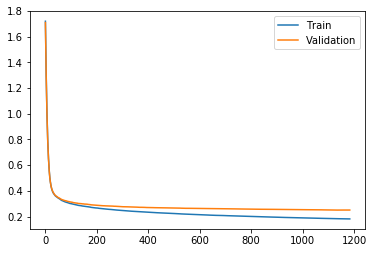

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.legend();

## MODEL INTERPRETATION

### Feature Importances

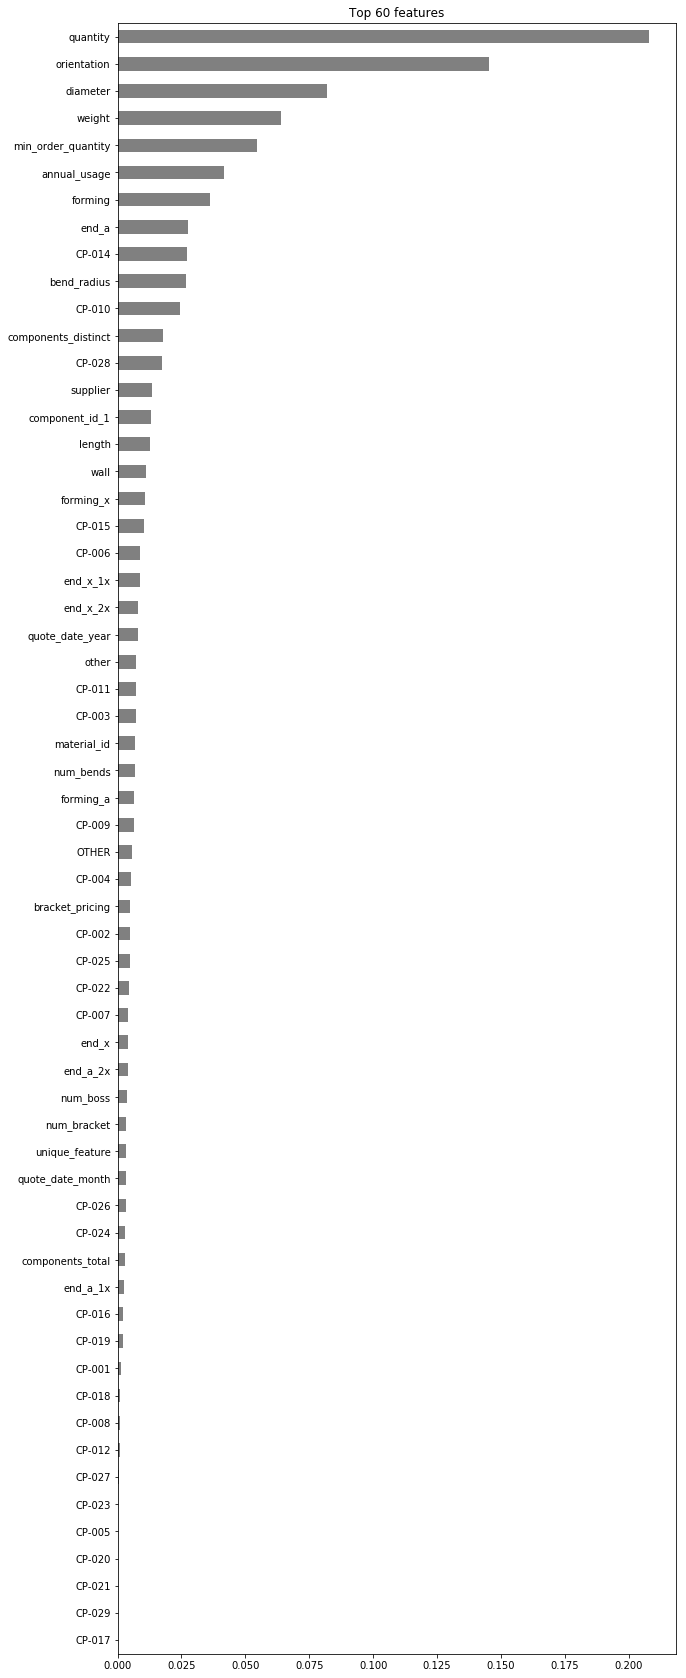

In [32]:
# Get feature importances
importances = pd.Series(model.feature_importances_, X_train_encoded.columns)

# Plot feature importances
n = len(X_train_encoded.columns)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### Permutation Importance

In [33]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.7375 ± 0.0055,quantity
0.2625 ± 0.0070,min_order_quantity
0.0640 ± 0.0003,annual_usage
0.0543 ± 0.0039,supplier
0.0451 ± 0.0009,diameter
0.0372 ± 0.0004,weight
0.0351 ± 0.0021,quote_date_year
0.0191 ± 0.0004,length
0.0100 ± 0.0001,wall
0.0076 ± 0.0004,forming


In [0]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [0]:
# use importances for feature selection
print('Shape before removing features:', X_train.shape)

In [0]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_val = X_val[features]

In [40]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_val_encoded)
print(f'Validation RMSLE', rmse(y_val_log, y_pred_log))

[17:59:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSLE 0.25147810540403587


### Partial Dependence Plots

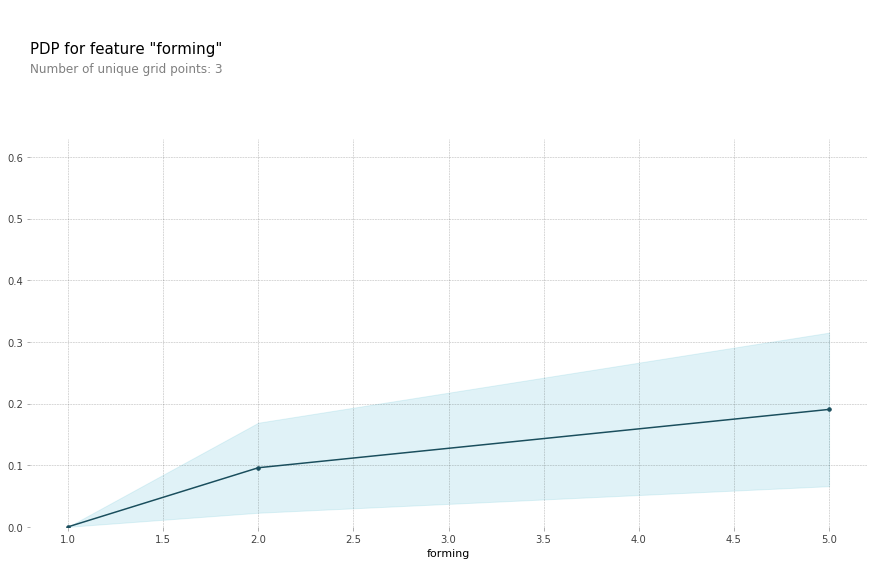

In [41]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'forming'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

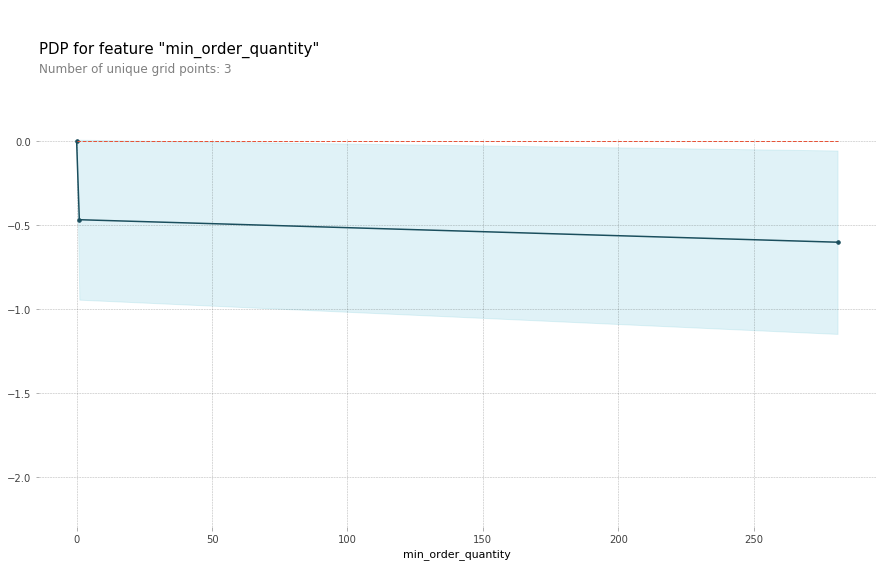

In [42]:
feature = 'min_order_quantity'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

### Partial Dependence Plots with 2 features

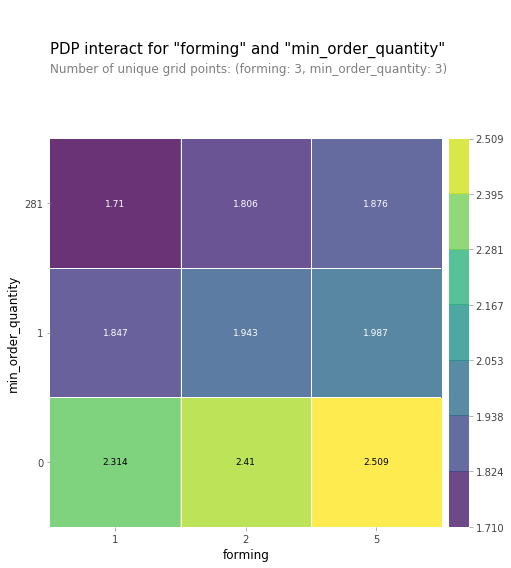

In [43]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['forming', 'min_order_quantity']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

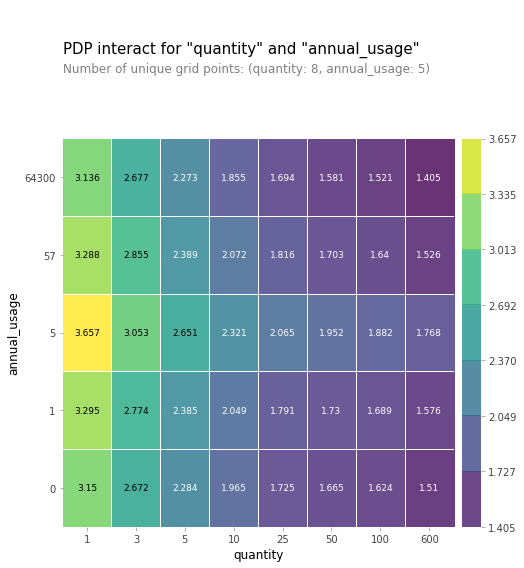

In [44]:
features = ['quantity', 'annual_usage']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);